In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from imageio import mimwrite
import numpy as np
from skimage import img_as_uint
from pathlib import Path

2023-01-18 13:57:43,633 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2023-01-18 13:57:56,121 - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


AttributeError: 'BNXItem' object has no attribute 'simulated'

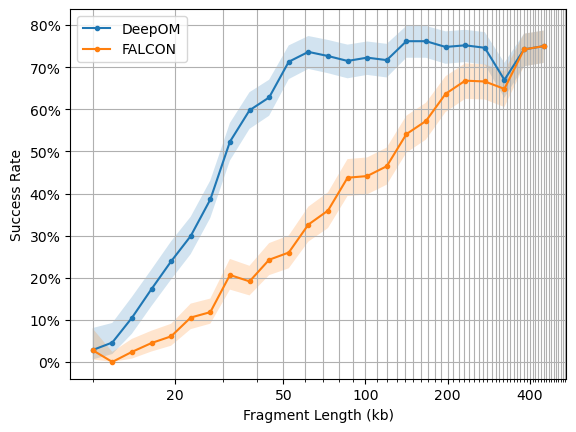

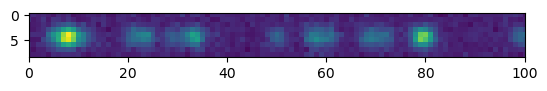

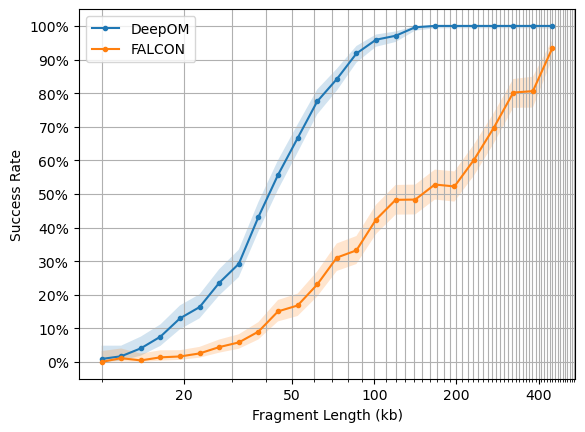

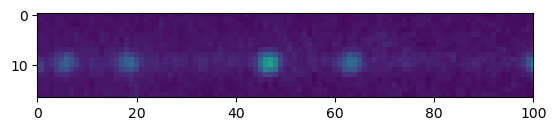

In [31]:
from deepom.bionano_compare import *
from deepom.bionano_utils import *

report = BionanoCompareReport()
for report.run_name in ["20230117T165559Z", "20230118T001629Z"]:
    report.read_compute_results()
    report = report
    plt.figure()
    report.plot_compare_init()
    report.plot_aligner_accuracy()
    report.plot_aligner_falcon_accuracy()
    pyplot.legend()
    plt.figure()
    # print(report.aligner_items[0].crop_item.bnx_item.simulated.image)
    plt.imshow(report.aligner_items[0].crop_item.bnx_item.bionano_image.segment_image[0])
    plt.xlim(0, 100)

In [2]:
from deepom.falcon_compare import Falcon
from deepom.localizer import LocalizerModule, default_rng, Config
localizer_module = LocalizerModule(sparsity=2000, nominal_num_labels_fragment=32)
localizer_module.device = "cpu"
localizer_module.checkpoint_search_dir = Config.CHECKPOINT_SEARCH_DIR
localizer_module.load_checkpoint = True
localizer_module.init_ensure_module()

BasicUNet features: (32, 32, 64, 128, 256, 32).
loading checkpoint:  /home/ynogin/Dropbox/code/DeepOM/data/pretrained/checkpoint.pickle 




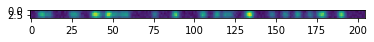

In [5]:
localizer_module.rng = default_rng(seed=4)

data_item = localizer_module.make_data()
data_item.lat_size_min = 9
data_item.stray_density = 1e-9
data_item.make_target()
inference_item = localizer_module.inference_item(data_item.image[:, 2:-2, :])
plt.imshow(inference_item.image_input)

(9, 205)

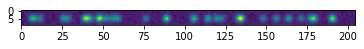

In [6]:
data_dir = Path.home() / "data"
image_file = data_dir / "image.tif"
image = data_item.image[0]
image = img_as_uint(image)
mimwrite(image_file, image[None])
plt.imshow(image)
image.shape

In [7]:
falcon = Falcon()
falcon.start()

In [8]:
locs = falcon(image_file)
len(locs.x)

FALCON GPU start...
frames no. 1 ~ 1 are reconstructing...


27

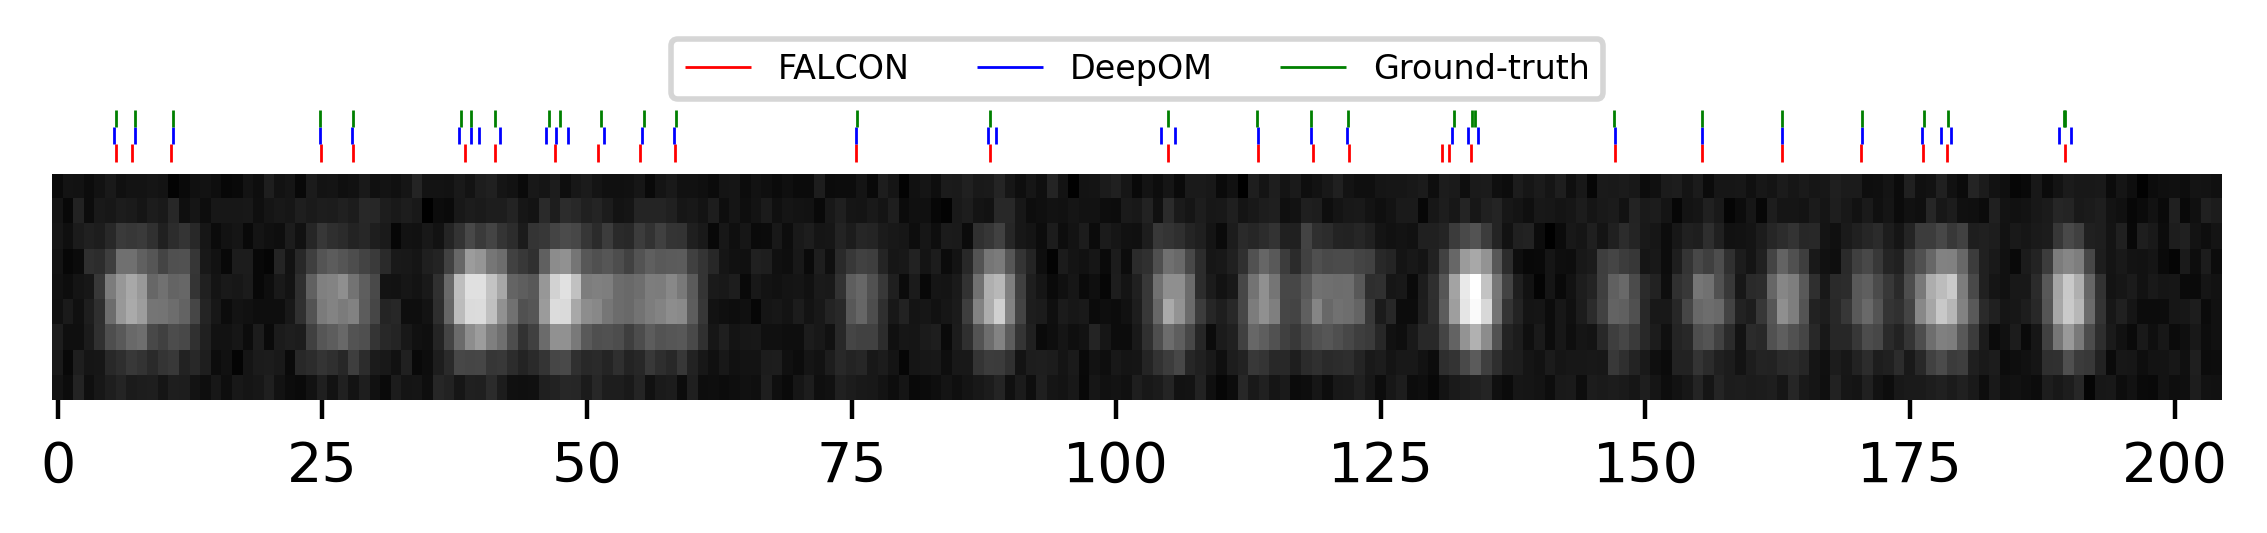

In [9]:
from imageio import mimread
fig, axs = plt.subplots(
    figsize=(7, 1),
    dpi=400,
    nrows=2,
    sharex=True,
    gridspec_kw=dict(height_ratios=[1, 3], hspace=0),
)

image = mimread(image_file)[0]
labeled_pos = data_item.labeled_coords.T[1]

ax = axs[0]
objs = ax.eventplot(
    [
        locs.x - 1,
        inference_item.loc_pred - .5,
        labeled_pos - .5,
    ],
    colors="rbg",
    linewidths=.5,
    linelengths=1
)
ax.set_frame_on(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = axs[1]
ax.imshow(image, cmap="gray", aspect="auto")
ax.set_frame_on(False)
ax.get_yaxis().set_visible(False)
plt.sca(axs[0])
# plt.ylim(0, .5)
plt.legend(objs, 
           ["FALCON", 
            "DeepOM",
            "Ground-truth", 
            ],
              ncol=3, loc="upper center",
              fontsize=6,
              bbox_to_anchor=(0.5, 2)
              )
# set_formatter(lambda x, _: int((x * data_item.scale) / 1000))
# plt.gca().add_artist(
#     ScaleBar(scalebar_scale, color="w", box_alpha=0, scale_loc="top", location="upper right", width_fraction=.02,
#              sep=0))
# plt.xlabel("sequence position (kb)")
# plt.xlim(None, 100)